## Importing the relevant libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



## Loading the images

In [11]:
img_path = '/kaggle/input/flickr8k/Images/'
images = glob(img_path+'*.jpg')
images[:5]

['/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg']

In [12]:
len(images)

8091

## Loading the captions

In [13]:
captions = open('/kaggle/input/flickr8k/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [14]:
len(captions)

40457

## Downloading the ResNet50 inception model

In [16]:
inception_model = ResNet50(include_top=True)
inception_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [17]:
last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model 
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Extracting features from images

In [18]:
img_features = {}
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3) # Reshaping image to the dimensions of a single image
    features = model.predict(img).reshape(2048,) # Feature extraction from images
    img_name = img_path.split('/')[-1] # Extracting image name
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images as using more than 1500 images leads to overloading memory issues
    if count == 1500:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
50
1/1 [==============================] - 0s 27ms/step
100
1/1 [==============================] - 0s 30ms/step
150
1/1 [==============================] - 0s 31ms/step
200
1/1 [==============================] - 0s 27ms/step
250
1/1 [==============================] - 0s 28ms/step
300
1/1 [==============================] - 0s 28ms/step
350
1/1 [==============================] - 0s 27ms/step
400
1/1 [==============================] - 0s 27ms/step
450
1/1 [==============================] - 0s 26ms/step
500
1/1 [==============================] - 0s 28ms/step
550
1/1 [==============================] - 0s 29ms/step
600
1/1 [==============================] - 0s 27ms/step
650
1/1 [==============================] - 0s 38ms/step
700
1/1 [==============================] - 0s 32ms/step
750
1/1 [==============================] - 0s 30ms/step
800
1/1 [==============================] - 0s 28ms/step
850
1/1 [==============================] - 0s 27ms/st

In [19]:
len(img_features)

1500

## Preprocessing the captions text

In [20]:
captions = captions[1:]
captions[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [21]:
captions[8].split(',')[1]

'Two dogs of different breeds looking at each other on the road .'

In [22]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions 
    except:
        break

In [23]:
len(captions_dict)

1500

In [24]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [25]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

## Creating vocabulary of the entire text corpus

In [26]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [27]:
len(count_words) # Vocab size

4031

In [28]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [29]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [30]:
max_len

34

In [31]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

4031

### Building a custom generator function to generate input image features and the text to be generated as output

In [32]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [33]:
X, y_in, y_out = generator(img_features,captions_dict)

In [34]:
len(X), len(y_in), len(y_out)

(92038, 92038, 92038)

In [35]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [36]:
X.shape, y_in.shape, y_out.shape

((92038, 2048), (92038, 34), (92038, 4032))

## Creating model architecture

In [37]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

img_model.summary()

# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

captions_model.summary()

# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=512,return_sequences=False)(output)
# Output Layer 
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 34, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           516096    
                                                                 
 lstm (LSTM)                 (None, 34, 256)           394240    
                            

## Model training

In [31]:
mc = ModelCheckpoint('image_caption_generator.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

final_model.fit([X,y_in],
                y_out,
                batch_size=512,
                epochs=50,
                callbacks=[mc, es]
                )

Epoch 1/50
180/180 [==============================] - ETA: 0s - loss: 5.3418 - accuracy: 0.1141
Epoch 1: accuracy improved from -inf to 0.11415, saving model to image_caption_generator.h5
180/180 [==============================] - 28s 122ms/step - loss: 5.3418 - accuracy: 0.1141
Epoch 2/50
180/180 [==============================] - ETA: 0s - loss: 5.1688 - accuracy: 0.1183
Epoch 2: accuracy improved from 0.11415 to 0.11826, saving model to image_caption_generator.h5
180/180 [==============================] - 17s 94ms/step - loss: 5.1688 - accuracy: 0.1183
Epoch 3/50
180/180 [==============================] - ETA: 0s - loss: 5.0979 - accuracy: 0.1191
Epoch 3: accuracy improved from 0.11826 to 0.11912, saving model to image_caption_generator.h5
180/180 [==============================] - 16s 91ms/step - loss: 5.0979 - accuracy: 0.1191
Epoch 4/50
180/180 [==============================] - ETA: 0s - loss: 5.0256 - accuracy: 0.1196
Epoch 4: accuracy improved from 0.11912 to 0.11965, saving m

In [33]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

## Saving the final trained model and the vocabulary dictionary

In [34]:
final_model.save('image_caption_generator.h5')

In [36]:
np.save('vocab.npy',count_words)

## Generating sample predictions

In [37]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

1/1 [==============================] - 0s 22ms/step


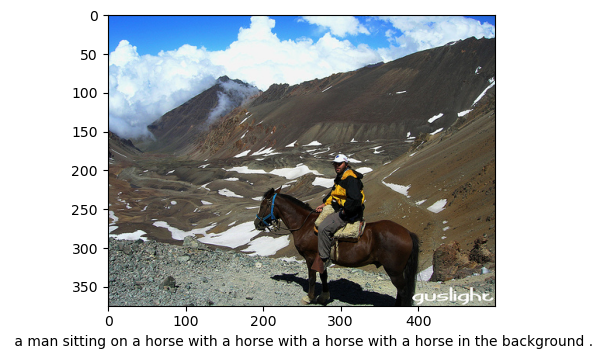

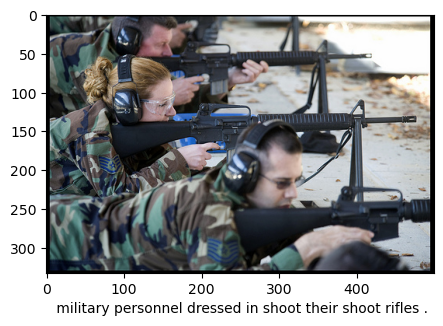

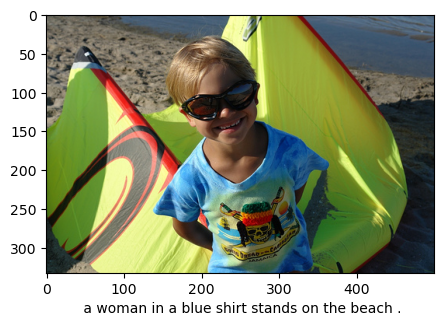

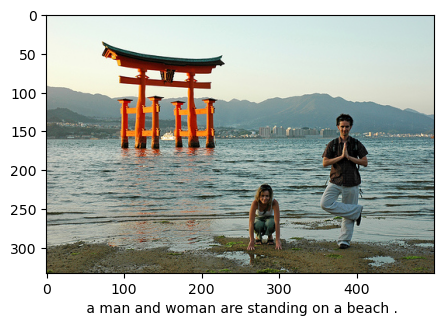

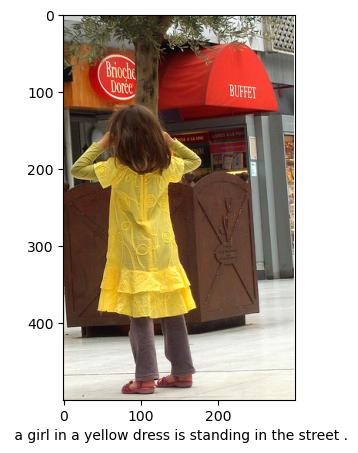

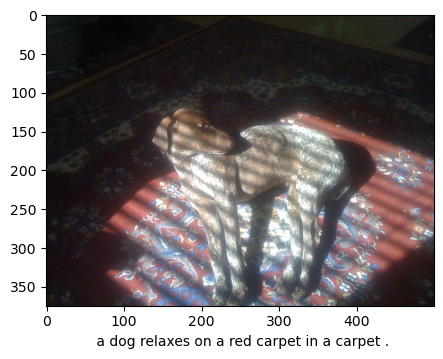

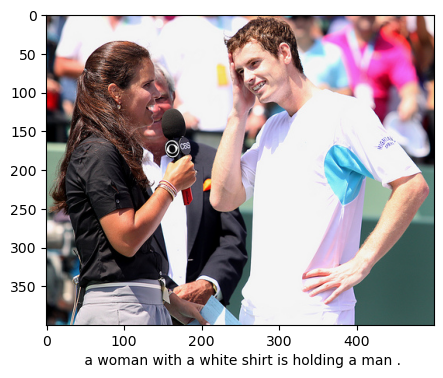

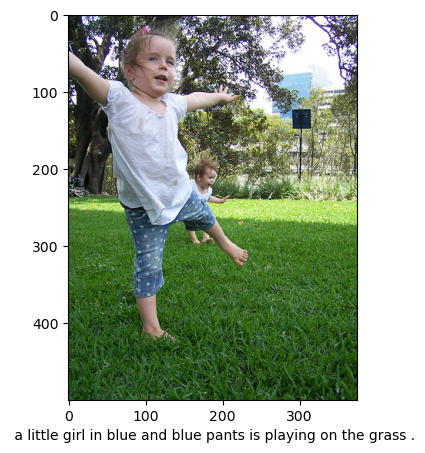

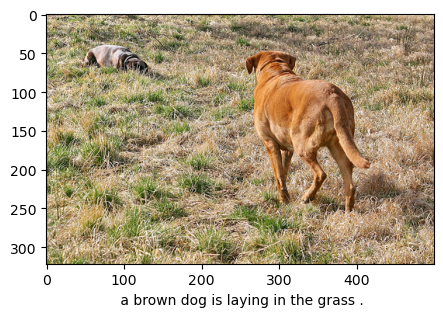

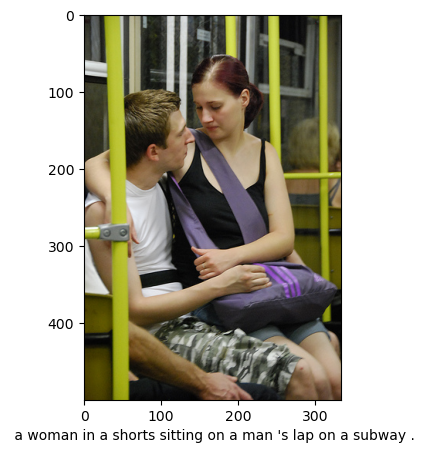

In [38]:
for i in range(10):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text
    
    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []
        
        for i in pred_text:
            encoded.append(count_words[i])
        
        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)
    
    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)

### Enhancing the model using Bahdanau attention mechanism

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding, LSTM, Input, Add
from tensorflow.keras.models import Model

class BahdanauAttention(Layer):

    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)  # To transform the features
        self.W2 = Dense(units)  # To transform the hidden state
        self.V = Dense(1)       # To calculate the score

    def call(self, features, hidden_state):
        # Expand hidden state dimensions to match feature dimensions
        hidden_state_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        # Score calculation
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_state_with_time_axis)))
        
        # Attention weights (softmax over the scores)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Weighted sum (context vector)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Define model parameters
# vocab_size = 5000
vocab_size = len(count_words)+1
# max_length = 30
max_length = max_len
embedding_dim = 256
units = 512

# Inputs
image_input = Input(shape=(2048,))  # ResNet features
caption_input = Input(shape=(max_length,))

# Embedding and LSTM layers
embedding = Embedding(vocab_size, embedding_dim)(caption_input)
lstm = LSTM(units, return_sequences=True, return_state=True)
lstm_out, hidden_state, cell_state = lstm(embedding)

# Attention mechanism
attention = BahdanauAttention(units)
context_vector, attention_weights = attention(image_input, hidden_state)

# Project context vector to match LSTM output dimensions
context_vector_dense = Dense(units)(context_vector)

# Combine context vector and LSTM output
decoder_input = Add()([context_vector_dense, hidden_state])
outputs = Dense(vocab_size, activation='softmax')(decoder_input)

# Build the model
enhanced_caption_model = Model(inputs=[image_input, caption_input], outputs=outputs)
# enhanced_caption_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
enhanced_caption_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')


# enhanced_caption_model.compile(optimizer='adam', loss='categorical_crossentropy')

print(enhanced_caption_model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 256)      1032192     ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 34, 512),    1574912     ['embedding_1[0][0]']            
                                 (None, 512),                                               

In [41]:
mc = ModelCheckpoint('image_caption_generator_new.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

# enhanced_caption_model.fit([X,y_in],
#                 y_out,
#                 batch_size=512,
#                 callbacks=mc,
#                 epochs=200)

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

enhanced_caption_model.fit([X, y_in], 
                            y_out, 
                            batch_size=128,  # Adjusted batch size
                            epochs=50,  # Reduce to a reasonable range
                            callbacks=[mc, es])


Epoch 1/50
720/720 [==============================] - ETA: 0s - loss: 5.6312 - accuracy: 0.1078
Epoch 1: accuracy improved from -inf to 0.10781, saving model to image_caption_generator_new.h5
720/720 [==============================] - 39s 49ms/step - loss: 5.6312 - accuracy: 0.1078
Epoch 2/50
720/720 [==============================] - ETA: 0s - loss: 5.4437 - accuracy: 0.1179
Epoch 2: accuracy improved from 0.10781 to 0.11785, saving model to image_caption_generator_new.h5
720/720 [==============================] - 22s 31ms/step - loss: 5.4437 - accuracy: 0.1179
Epoch 3/50
720/720 [==============================] - ETA: 0s - loss: 5.4358 - accuracy: 0.1170
Epoch 3: accuracy did not improve from 0.11785
720/720 [==============================] - 20s 28ms/step - loss: 5.4358 - accuracy: 0.1170
Epoch 4/50
720/720 [==============================] - ETA: 0s - loss: 5.4453 - accuracy: 0.1162
Epoch 4: accuracy did not improve from 0.11785
720/720 [==============================] - 20s 28ms/st

### Using glove for model enhanchment

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding, LSTM, Input, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenize the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
count_words = len(tokenizer.word_index)  # Vocabulary size

# Convert captions to sequences
sequences = tokenizer.texts_to_sequences(captions)
# Pad sequences to ensure uniform input size
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')



# Load GloVe embeddings (100d)
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embedding_dim = 100
embedding_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coef


# Create the embedding matrix
vocab_size = len(tokenizer.word_index) + 1  # Adjust this based on your tokenizer
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
class BahdanauAttention(Layer):
    """Bahdanau attention mechanism."""
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)  # To transform the features
        self.W2 = Dense(units)  # To transform the hidden state
        self.V = Dense(1)       # To calculate the score

    def call(self, features, hidden_state):
        # Expand hidden state dimensions to match feature dimensions
        hidden_state_with_time_axis = tf.expand_dims(hidden_state, 1)

        # Score calculation
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_state_with_time_axis)))

        # Attention weights (softmax over the scores)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Weighted sum (context vector)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [41]:

# Define model parameters
units = 512

# Inputs
image_input = Input(shape=(2048,))  # ResNet features
caption_input = Input(shape=(max_len,))

# Embedding layer with pre-trained GloVe weights
embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(caption_input)

# LSTM layers
lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5)
lstm_out, hidden_state, cell_state = lstm(embedding)

# Attention mechanism
attention = BahdanauAttention(units)
context_vector, attention_weights = attention(image_input, hidden_state)

# Project context vector to match LSTM output dimensions
context_vector_dense = Dense(units, activation='relu')(context_vector)
context_vector_dense = Dropout(0.5)(context_vector_dense)

# Combine context vector and LSTM output
decoder_input = Add()([context_vector_dense, hidden_state])
outputs = Dense(vocab_size, activation='softmax')(decoder_input)

# Build the model
enhanced_caption_model = Model(inputs=[image_input, caption_input], outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
enhanced_caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(enhanced_caption_model.summary())


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 100)      2467700     ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 34, 512),    1255424     ['embedding_1[0][0]']            
                                 (None, 512),                                               

In [ ]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks for training
mc = ModelCheckpoint('image_caption_generator.h5', monitor='val_accuracy', 
                     verbose=1, mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Ensure labels are properly encoded
y_out = to_categorical(y_out, num_classes=vocab_size)  # One-hot encoding for categorical crossentropy

# Now fit the model
enhanced_caption_model.fit(
    [X, y_in], 
    y_out, 
    batch_size=32,  # Reduced batch size
    epochs=50, 
    validation_split=0.2, 
    callbacks=[mc, es, reduce_lr]
)



In [ ]:
final_model.save('image_caption_generator_v2.h5')


In [ ]:
np.save('vocab_v2.npy',count_words)